In [1]:
using HTTP
using ZipFile
using StringEncodings

# 青空文庫の小説のzipファイルのURLからデータを取得
function getaozora(url::String)
    # urlからzipファイルを読み込み
    dat = HTTP.get(url)

    # zipファイルから圧縮前の元データを取得
    r = ZipFile.Reader(IOBuffer(dat.body))

    # 最初に見つかったテキストファイルを取得する
    f = nothing
    for file in r.files
        if findlast(".txt", file.name) != nothing
            f = file
            break
        end
    end
    close(r)
    
    # 文字コードShiftJISで記述されたファイルを読み込む：CP932を指定する
    lines = readlines(f, enc"CP932")
end

getaozora (generic function with 1 method)

In [2]:
# 青空文庫のテキストデータを加工して、形態素解析できるようにする
#   ・注釈行・奥付やルビ・入力者注を削除
#   ・句点で改行させ、不要な空白・空行を除去
function correctaozora(lines)
    # 先頭の注釈行判定用
    note_line = r"^--------"
    is_note = false
    # 末尾の奥付判定用
    endmark = r"^(底本|底本の親本|翻訳の底本|初出)："
    # 最終結果の格納領域
    new_lines = []

    for line in lines
        # 不要行を削除する（new_lineへの登録をskipすることで実現）
        ## 先頭の注釈行の削除
        if is_note
            if occursin(note_line, line)
                is_note = false
            end
            continue
        else
            if occursin(note_line, line)
                is_note = true
                continue
            end
        end
        ## 末尾の奥付を削除
        if occursin(endmark, line)
            break
        end
        # 不要行削除ここまで
    
        # ルビ、および、入力者注の削除
        line = replace(line, r"［＃[^］]+］" => "")
        line = replace(line, r"《[^》]+》" => "")
    
        # 形態素解析に長文を渡したり、不要な呼び出しをしないように、文字列を調整
        ## 句点「。」の後で分割する
        slines = split(replace(line, r"。" => "。\n"), "\n")
        for ll in slines
            ## 行頭の空白文字列を削除
            ll = replace(ll, r"^[　 ]+" => "")
            ## 空行は削除
            if length(ll) == 0
                continue
            end
            # 処理済み文字列を格納
            push!(new_lines, ll)
        end
    end
    new_lines
end

correctaozora (generic function with 1 method)

In [3]:
using Awabi

function countmorph(lines)
    # 形態素解析器の設定
    ## Linux / Mac
    #tokenizer = Tokenizer()
    ## Windows：
    #dic = Dict("dicdir" => "C:\\Program Files (x86)\\MeCab\\dic\\ipadic")
    #tokenizer = Tokenizer(dic)
    ## SageMaker Studio Lab
    rcfile = "/home/studio-lab-user/mecab/etc/mecabrc"
    tokenizer = Tokenizer(rcfile)

    # 数え上げ格納領域
    word_counts = Dict{String, Int}()

    # 形態素解析＆数え上げ
    for line in lines
        # 1文を形態素解析
        try
            tokens = tokenize(tokenizer, line)
            new_tokens = []
            for token in tokens
                attr = split(token[2], ",")
                hinsi = attr[1]
                hinsi2 = attr[2]
                surface = token[1] # 表記
                basic = (attr[7] != "*") ? attr[7] : surface   # 形態素の基本形
                # 一文字のひらがな・カタカナ・長音「ー」・波線「〜」を対象外にする
                if hinsi in ["名詞", "動詞", "形容詞"] && !(hinsi2 in ["接尾", "非自立"]) &&
                    (length(surface) > 1 || ((surface < "ぁ" || surface > "ヶ") && !(surface in ["ー", "～"])))
                    push!(new_tokens, basic)
                end
            end
            # 行中の形態素の重複を除去
            #unique!(new_tokens)
            # 形態素数を数え上げ
            for surface in new_tokens
                word_counts[surface] = get(word_counts, surface, 0) + 1
            end
        catch
            # pass
        end
    end
    word_counts
end

countmorph (generic function with 1 method)

In [4]:
# zipファイルのURL
# 夏目漱石
url_natume = [
    "https://www.aozora.gr.jp/cards/000148/files/773_ruby_5968.zip",    # こころ
    "https://www.aozora.gr.jp/cards/000148/files/776_ruby_6020.zip",    # 草枕
    "https://www.aozora.gr.jp/cards/000148/files/761_ruby_1861.zip",    # 虞美人草
    "https://www.aozora.gr.jp/cards/000148/files/775_ruby_2064.zip",    # 行人
    "https://www.aozora.gr.jp/cards/000148/files/794_ruby_4237.zip",    # 三四郎
    "https://www.aozora.gr.jp/cards/000148/files/56143_ruby_50824.zip", # それから
    "https://www.aozora.gr.jp/cards/000148/files/752_ruby_2438.zip",    # 坊っちゃん
    "https://www.aozora.gr.jp/cards/000148/files/782_ruby_2315.zip",    # 明暗
    "https://www.aozora.gr.jp/cards/000148/files/785_ruby_1656.zip",    # 門
    "https://www.aozora.gr.jp/cards/000148/files/789_ruby_5639.zip",    # 吾輩は猫である
    ]

# 太宰治
url_dazai = [
    "https://www.aozora.gr.jp/cards/000035/files/301_ruby_5915.zip",    # 人間失格
    "https://www.aozora.gr.jp/cards/000035/files/1565_ruby_8220.zip",   # 斜陽
    "https://www.aozora.gr.jp/cards/000035/files/1567_ruby_4948.zip",   # 走れメロス
    "https://www.aozora.gr.jp/cards/000035/files/307_ruby_3042.zip",    # お伽草紙
    "https://www.aozora.gr.jp/cards/000035/files/275_ruby_1532.zip",    # 女生徒
    "https://www.aozora.gr.jp/cards/000035/files/2282_ruby_1996.zip",   # 津軽
    "https://www.aozora.gr.jp/cards/000035/files/1566_ruby_8222.zip",   # パンドラの匣
    "https://www.aozora.gr.jp/cards/000035/files/2253_ruby_1031.zip",   # ヴィヨンの妻
    "https://www.aozora.gr.jp/cards/000035/files/258_ruby_20178.zip",   # グッド・バイ
    "https://www.aozora.gr.jp/cards/000035/files/260_ruby_34636.zip",   # 逆行
    ]

# 芥川龍之介
url_akutagawa = [
    "https://www.aozora.gr.jp/cards/000879/files/92_ruby_164.zip",      # 蜘蛛の糸
    "https://www.aozora.gr.jp/cards/000879/files/127_ruby_150.zip",     # 羅生門
    "https://www.aozora.gr.jp/cards/000879/files/43015_ruby_17393.zip", # 杜子春
    "https://www.aozora.gr.jp/cards/000879/files/42377_ruby_34744.zip", # 歯車
    "https://www.aozora.gr.jp/cards/000879/files/179_ruby_168.zip",     # 薮の中
    "https://www.aozora.gr.jp/cards/000879/files/19_ruby_306.zip",      # 或阿呆の一生
    "https://www.aozora.gr.jp/cards/000879/files/55_ruby_1843.zip",     # 芋粥
    "https://www.aozora.gr.jp/cards/000879/files/60_ruby_821.zip",      # 地獄変
    "https://www.aozora.gr.jp/cards/000879/files/43016_ruby_16663.zip", # トロッコ
    "https://www.aozora.gr.jp/cards/000879/files/69_ruby_1321.zip",     # 河童
    ]

# 森鴎外
url_ougai = [
    "https://www.aozora.gr.jp/cards/000129/files/58126_ruby_73643.zip", # 舞姫
    "https://www.aozora.gr.jp/cards/000129/files/695_ruby_22805.zip",   # ヰタ・セクスアリス
    "https://www.aozora.gr.jp/cards/000129/files/45224_ruby_19890.zip", # 雁
    "https://www.aozora.gr.jp/cards/000019/files/4376_ruby_18828.zip",  # 即興詩人
    "https://www.aozora.gr.jp/cards/000129/files/673_ruby_23254.zip",   # 阿部一族
    "https://www.aozora.gr.jp/cards/000129/files/45245_ruby_21882.zip", # 高瀬舟
    "https://www.aozora.gr.jp/cards/000129/files/689_ruby_23256.zip",   # 山椒大夫
    "https://www.aozora.gr.jp/cards/000129/files/2058_ruby_19627.zip",  # 渋江抽斎
    "https://www.aozora.gr.jp/cards/000129/files/2522_ruby_5001.zip",   # 青年
    "https://www.aozora.gr.jp/cards/000129/files/676_ruby_23235.zip",   # 百物語
    ]

# 国木田独歩
url_kunikida = [
    "https://www.aozora.gr.jp/cards/000038/files/329_ruby_5709.zip",    # 武蔵野
    "https://www.aozora.gr.jp/cards/000038/files/323_ruby_352.zip",     # 牛肉と馬鈴薯
    "https://www.aozora.gr.jp/cards/000038/files/1409_ruby_34466.zip",  # 忘れえぬ人々
    "https://www.aozora.gr.jp/cards/000038/files/332_ruby_337.zip",     # 酒中日記
    "https://www.aozora.gr.jp/cards/000038/files/1057_ruby_4478.zip",   # 春の鳥
    "https://www.aozora.gr.jp/cards/000038/files/42199_ruby_48057.zip", # おとずれ
    "https://www.aozora.gr.jp/cards/000038/files/336_ruby_1953.zip",    # 運命論者
    "https://www.aozora.gr.jp/cards/000038/files/327_ruby_1970.zip",    # 恋を恋する人
    "https://www.aozora.gr.jp/cards/000038/files/42205_ruby_34464.zip", # 初恋
    "https://www.aozora.gr.jp/cards/000038/files/324_ruby_2371.zip",    # 非凡なる凡人
    ]

# 江戸川乱歩
url_edogawa = [
    "https://www.aozora.gr.jp/cards/001779/files/56650_ruby_58200.zip", # D坂の殺人事件
    "https://www.aozora.gr.jp/cards/001779/files/57228_ruby_58697.zip", # 怪人二十面相
    "https://www.aozora.gr.jp/cards/001779/files/56669_ruby_58718.zip", # 少年探偵団
    "https://www.aozora.gr.jp/cards/001779/files/56684_ruby_65241.zip", # 夜光人間
    "https://www.aozora.gr.jp/cards/001779/files/57849_ruby_71883.zip", # 孤島の鬼
    "https://www.aozora.gr.jp/cards/001779/files/56671_ruby_59594.zip", # 青銅の魔人
    "https://www.aozora.gr.jp/cards/001779/files/57405_ruby_59991.zip", # 黒蜥蜴
    "https://www.aozora.gr.jp/cards/001779/files/57241_ruby_73666.zip", # 黄金仮面
    "https://www.aozora.gr.jp/cards/001779/files/56651_ruby_58728.zip", # パノラマ島綺譚
    "https://www.aozora.gr.jp/cards/001779/files/57229_ruby_61307.zip", # 透明怪人
    ]

# 宮沢賢治
url_miyazawa = [
    "https://www.aozora.gr.jp/cards/000081/files/43737_ruby_19028.zip", # 銀河鉄道の夜
    "https://www.aozora.gr.jp/cards/000081/files/1943_ruby_29612.zip",  # 風の又三郎
    "https://www.aozora.gr.jp/cards/000081/files/473_ruby_467.zip",     # よだかの星
    "https://www.aozora.gr.jp/cards/000081/files/466_ruby_1478.zip",    # オツベルと象
    "https://www.aozora.gr.jp/cards/000081/files/43754_ruby_17594.zip", # 注文の多い料理店
    "https://www.aozora.gr.jp/cards/000081/files/470_ruby_3987.zip",    # セロ弾きのゴーシュ
    "https://www.aozora.gr.jp/cards/000081/files/454_ruby_635.zip",     # 毒もみのすきな署長さん
    "https://www.aozora.gr.jp/cards/000081/files/1924_ruby_14067.zip",  # グスコーブドリの伝記
    "https://www.aozora.gr.jp/cards/000081/files/464_ruby_19940.zip",   # 猫の事務所
    "https://www.aozora.gr.jp/cards/000081/files/46605_ruby_29758.zip", # やまなし
    ]

# 谷崎潤一郎
url_tanizaki = [
    "https://www.aozora.gr.jp/cards/001383/files/56642_ruby_59574.zip", # 陰翳礼讃
    "https://www.aozora.gr.jp/cards/001383/files/58093_ruby_62048.zip", # 痴人の愛
    "https://www.aozora.gr.jp/cards/001383/files/56873_ruby_62034.zip", # 卍(まんじ)
    "https://www.aozora.gr.jp/cards/001383/files/59827_ruby_73151.zip", # 猫と庄造と二人のおんな
    "https://www.aozora.gr.jp/cards/001383/files/57442_ruby_65178.zip", # 金色の死
    "https://www.aozora.gr.jp/cards/001383/files/56866_ruby_58168.zip", # 春琴抄
    "https://www.aozora.gr.jp/cards/001383/files/56641_ruby_59456.zip", # 刺青
    "https://www.aozora.gr.jp/cards/001383/files/56771_ruby_60190.zip", # 瘋癲老人日記
    "https://www.aozora.gr.jp/cards/001383/files/56698_ruby_59448.zip", # 細雪（上） 
    "https://www.aozora.gr.jp/cards/001383/files/57416_ruby_71251.zip", # 細雪（中）
    "https://www.aozora.gr.jp/cards/001383/files/57394_ruby_73659.zip", # 細雪（下）
    "https://www.aozora.gr.jp/cards/001383/files/56874_ruby_68455.zip", # 蓼喰う虫
    ]

# 坂口安吾
url_sakaguchi = [
    "https://www.aozora.gr.jp/cards/001095/files/42620_ruby_21051.zip", # 堕落論
    "https://www.aozora.gr.jp/cards/001095/files/43001_ruby_51731.zip", # 吹雪物語
    "https://www.aozora.gr.jp/cards/001095/files/42618_ruby_21052.zip", # 桜の森の満開の下
    "https://www.aozora.gr.jp/cards/001095/files/42617_ruby_29709.zip", # 肝臓先生
    "https://www.aozora.gr.jp/cards/001095/files/42621_ruby_21262.zip", # 白痴 
    "https://www.aozora.gr.jp/cards/001095/files/42919_ruby_25114.zip", # 二流の人
    "https://www.aozora.gr.jp/cards/001095/files/45872_ruby_30473.zip", # 真珠
    "https://www.aozora.gr.jp/cards/001095/files/42616_ruby_20999.zip", # 風博士
    "https://www.aozora.gr.jp/cards/001095/files/42900_ruby_35135.zip", # 戦争と一人の女
    "https://www.aozora.gr.jp/cards/001095/files/42615_ruby_21263.zip", # 風と光と二十の私と
    ]

# ドイル アーサー・コナン
url_doyle = [
    "https://www.aozora.gr.jp/cards/000009/files/8_ruby_31219.zip",     # 赤毛連盟
    "https://www.aozora.gr.jp/cards/000009/files/43522_ruby_16831.zip", # 空家の冒険
    "https://www.aozora.gr.jp/cards/000009/files/50713_ruby_36984.zip", # 踊る人形
    "https://www.aozora.gr.jp/cards/000009/files/55882_ruby_50045.zip", # サセックスの吸血鬼
    "https://www.aozora.gr.jp/cards/000009/files/50717_ruby_36993.zip", # まだらのひも
    "https://www.aozora.gr.jp/cards/000009/files/226_ruby_31221.zip",   # ボヘミアの醜聞
    "https://www.aozora.gr.jp/cards/000009/files/50712_ruby_36970.zip", # 唇のねじれた男
    "https://www.aozora.gr.jp/cards/000009/files/50718_ruby_36995.zip", # 瀕死の探偵
    "https://www.aozora.gr.jp/cards/000009/files/50716_ruby_36991.zip", # グローリア・スコット号
    "https://www.aozora.gr.jp/cards/000009/files/54915_ruby_47227.zip", # 三枚の学生
    ]
urls = [url_natume, url_dazai, url_akutagawa, url_ougai, url_kunikida, url_edogawa, url_miyazawa, url_tanizaki, url_sakaguchi, url_doyle];

In [5]:
url = urls[1][1]   # こころ
lines = correctaozora(getaozora(url))
word_counts = countmorph(lines)

Dict{String, Int64} with 4852 entries:
  "騒ぐ" => 2
  "充ち… => 4
  "糸"   => 4
  "顧み… => 9
  "ため… => 2
  "あき… => 1
  "出す" => 67
  "近付… => 1
  "剣"   => 1
  "送金" => 1
  "なす… => 3
  "今頃" => 1
  "もっ… => 2
  "持物" => 1
  "重ん… => 1
  "細か… => 3
  "後生" => 1
  "附近" => 1
  "急ぐ" => 10
  "執る" => 7
  "攫む" => 5
  "味方" => 1
  "臆面" => 1
  "刺激" => 1
  "葬式" => 2
  ⋮      => ⋮

In [6]:
ordered_count = [c for (w,c) in sort(collect(word_counts), rev = true, by =x -> x[2]) ]

4852-element Vector{Int64}:
 2695
  597
  572
  507
  475
  414
  403
  388
  366
  314
  293
  269
  263
    ⋮
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1

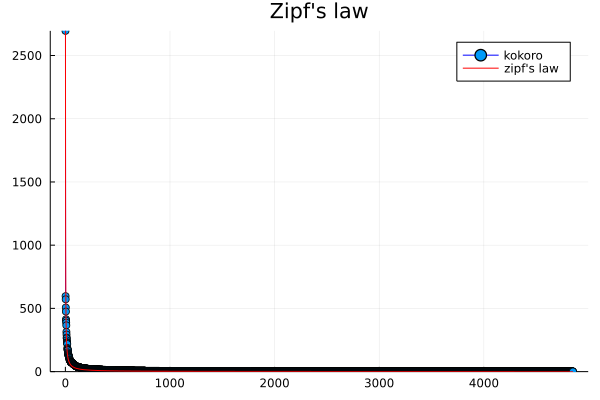

In [7]:
# ex1:何も考えずに全部表示
using Plots
base = ordered_count[1]
y_limit = base
p1 = plot(ordered_count, title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), label="kokoro")
plot!(p1, x->base/x, linecolor=:red, label="zipf's law")

In [8]:
# 保存
savefig(p1, "zipfslaw_ex1.png")

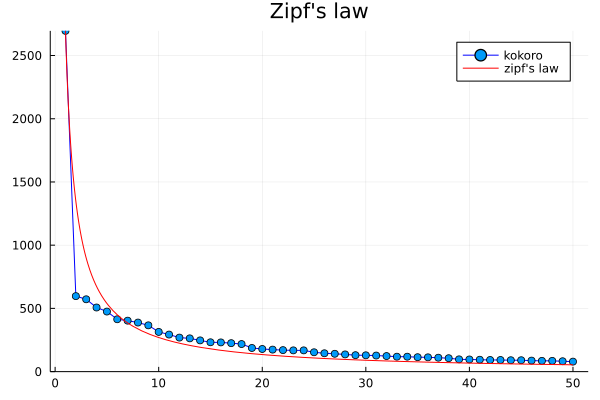

In [9]:
# ex2:上位50件を表示
using Plots
base = ordered_count[1]
y_limit = base
p2 = plot(ordered_count[1:50], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), label="kokoro")
plot!(p2, x->base/x, linecolor=:red, label="zipf's law")

In [10]:
# 保存
savefig(p2, "zipfslaw_ex2.png")

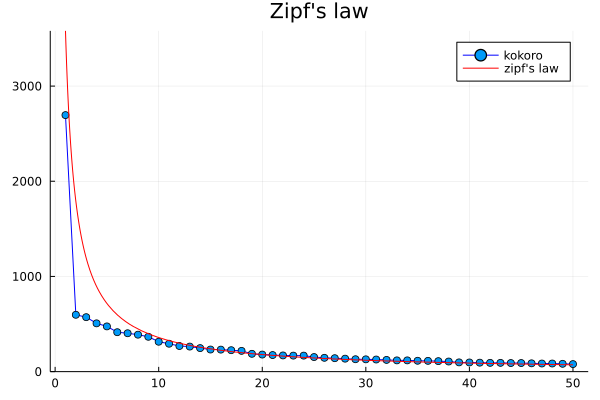

In [11]:
# ex3:20番目の値から基準を調整
using Plots
base = ordered_count[20] * 20
y_limit = base
p3 = plot(ordered_count[1:50], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), label="kokoro")
plot!(p3, x->base/x, linecolor=:red, label="zipf's law")

In [12]:
# 保存
savefig(p3, "zipfslaw_ex3.png")

In [13]:
# 夏目漱石の10本の小説
# 【注意】時間がかかります
word_counts = Dict{String, Int}()
for url in url_natume
    lines = correctaozora(getaozora(url))
    word_counts_one = countmorph(lines)
    word_counts = mergewith(+, word_counts, word_counts_one)
end
ordered_count = [c for (w,c) in sort(collect(word_counts), rev = true, by =x -> x[2]) ]

21163-element Vector{Int64}:
 6453
 5351
 5156
 5086
 4825
 4223
 3686
 3520
 3109
 3104
 3055
 2868
 2827
    ⋮
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1
    1

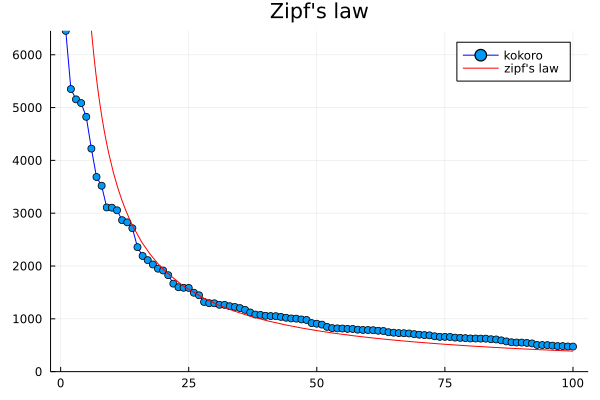

In [14]:
# ex4:上位100件を表示
using Plots
base = ordered_count[30]*30
y_limit = ordered_count[1]
p4 = plot(ordered_count[1:100], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), label="kokoro")
plot!(p4, x->base/x, linecolor=:red, label="zipf's law")

In [15]:
# 保存
savefig(p4, "zipfslaw_ex4.png")

In [16]:
# 10人の作家×10本の小説
# 【注意】すごく、時間がかかります
word_counts = Dict{String, Int}()
for url_in_writer in urls
    for url in url_in_writer
        lines = correctaozora(getaozora(url))
        word_counts_one = countmorph(lines)
        word_counts = mergewith(+, word_counts, word_counts_one)
    end
end

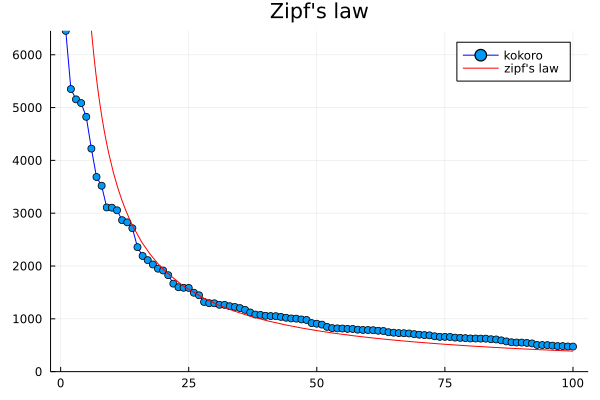

In [17]:
# ex5:上位100件を表示
using Plots
base = ordered_count[30]*30
y_limit = ordered_count[1]
p5 = plot(ordered_count[1:100], title="Zipf's law", markershape=:circle, linecolor=:blue, ylims=(0,y_limit), label="kokoro")
plot!(p5, x->base/x, linecolor=:red, label="zipf's law")

In [18]:
# 保存
savefig(p5, "zipfslaw_ex5.png")